# Reviewer request - compare distance-based decoders versus linear decoders

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
# import tools
import nibabel as nib
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Arial"
import pandas as pd
import time
from importlib import reload
import wbplot
import matplotlib.image as img 
import matplotlib.colors as clrs
from matplotlib import colorbar

# Set parameters

In [97]:
networkdef = np.loadtxt('../../data/cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('../../data/cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])
    
glasser = np.squeeze(nib.load('../../data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii').get_fdata())

figuredir = '../../docs/figures/manuscriptFigures/SFig_DecoderComparison/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

# Load in data

In [104]:
datadir = '../../data/results/MAIN/LayerID_Revision/'
decoding_types = ['logistic','similarity']
conditions = ['colorStim','oriStim','pitchStim','constantStim','rules']

df = {}
df['Condition'] = []
df['Decoding accuracy'] = []
df['Decoder'] = []
for decoder in decoding_types:
    for cond in conditions:
        tmp = np.loadtxt(datadir + cond + '_' + decoder + '.csv')
        acc = []
        for parcel in range(nParcels):
            roi_ind = np.where(glasser==parcel+1)[0]
            tmpacc = np.mean(tmp[roi_ind,0])
            if tmpacc>0:
                acc.append(tmpacc*100.0)
        for a in acc:
            df['Condition'].append(cond)
            if decoder=="similarity":
                df['Decoder'].append('distance')
            else:
                df['Decoder'].append(decoder)
            df['Decoding accuracy'].append(a)
df = pd.DataFrame(df)

Condition: colorStim
	Similarity vs. logistic: -0.19097222222221433 | t = 818.5 | p = 0.6156352445028257
Condition: oriStim
	Similarity vs. logistic: 1.1892361111111036 | t = 638.5 | p = 0.09290683920463509
Condition: pitchStim
	Similarity vs. logistic: 1.2326388888888786 | t = 41.0 | p = 0.30279541015625
Condition: constantStim
	Similarity vs. logistic: 1.909722222222225 | t = 31.5 | p = 0.12054443359375
Condition: rules
	Similarity vs. logistic: 1.2557870370370505 | t = 11483.5 | p = 9.649317115299886e-26


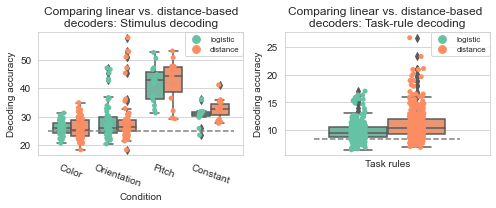

In [108]:
plt.figure(figsize=(7,3))
plt.subplot(121)
tmpdf = df.loc[df.Condition!='rules']
ax = sns.boxplot(x="Condition",y='Decoding accuracy',hue='Decoder',data=tmpdf,palette='Set2')
sns.stripplot(x="Condition",y='Decoding accuracy',hue='Decoder',data=tmpdf,dodge=True,palette='Set2')
plt.title('Comparing linear vs. distance-based\ndecoders: Stimulus decoding', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
plt.xticks(np.arange(4),['Color', 'Orientation', 'Pitch', 'Constant'],fontsize=10,rotation=-20)
plt.plot(np.arange(-0.5, 4.5),np.repeat(25,5),'grey',linestyle='--',label='Chance - 50%')
l = plt.legend(handles[-2:], labels[-2:], loc=1, borderaxespad=0., prop={'size': 8})
plt.tight_layout()

plt.subplot(122)
tmpdf = df.loc[df.Condition=='rules']
ax = sns.boxplot(x="Condition",y='Decoding accuracy',hue='Decoder',data=tmpdf,palette='Set2')
sns.stripplot(x="Condition",y='Decoding accuracy',hue='Decoder',data=tmpdf,dodge=True,palette='Set2')
plt.title('Comparing linear vs. distance-based \ndecoders: Task-rule decoding', fontsize=12)
handles, labels = ax.get_legend_handles_labels()
plt.xticks([])
plt.xlabel('Task rules',fontsize=10)
plt.plot(np.arange(-0.5, 1.5),np.repeat((1/12)*100,2),'grey',linestyle='--',label='Chance - 50%')
l = plt.legend(handles[-2:], labels[-2:], loc=1, borderaxespad=0., prop={'size': 8})
plt.tight_layout()
plt.savefig(figuredir + 'SFigDecodingComparison.png',dpi=300)

# Run statistical tests
for cond in conditions:
    tmpdf = df.loc[df.Condition==cond]
    accdiff = tmpdf['Decoding accuracy'][df.Decoder=='distance'].mean() - tmpdf['Decoding accuracy'][df.Decoder=='logistic'].mean()
    t, p = stats.wilcoxon(tmpdf['Decoding accuracy'][df.Decoder=='distance'].values,tmpdf['Decoding accuracy'][df.Decoder=='logistic'].values)
    print('Condition:', cond)
    print('\tSimilarity vs. logistic:', accdiff, '| t =', t, '| p =', p)